# Detección de COVID-19 con Radiografías de Tórax usando PyTorch

Clasificación de imágenes de radiografías de tórax en una de tres clases: Normal, Neumonía Viral, COVID-19

Notebook creado para el proyecto guiado [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) en Coursera

Dataset de [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) en Kaggle

# Importando Librerías

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.6.0+cpu


In [4]:
import os

def contar_elementos(carpeta):
    try:
        # Lista los elementos en la carpeta
        elementos = os.listdir(carpeta)
        
        # Cuenta el número de elementos
        total_elementos = len(elementos)
        
        print(f"La carpeta '{carpeta}' contiene {total_elementos} elementos.")
        return total_elementos
    except FileNotFoundError:
        print(f"La carpeta '{carpeta}' no existe.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")
        

Classes = ['COVID', 'Normal', 'Viral Pneumonia']

conteos = []

for i in Classes:
    carpeta = f'COVID-19 Radiography Database/{i}'
    conteo = contar_elementos(carpeta)
    conteos.append(conteo)

La carpeta 'COVID-19 Radiography Database/COVID' contiene 3616 elementos.
La carpeta 'COVID-19 Radiography Database/Normal' contiene 10192 elementos.
La carpeta 'COVID-19 Radiography Database/Viral Pneumonia' contiene 1345 elementos.


In [5]:
conteos

[3616, 10192, 1345]

In [28]:
import plotly.express as px

fig = px.pie(values = conteos[0:3], names = Classes[0:3], color = ['G1', 'G2', 'G3'],
             color_discrete_map = {'G1': '#f5e6ff','G2': '#c38aec','G3': '#e0b3ff'}, hole = 0.5,  title = 'Distribución por tipo de Registro')
# Update the layout to make the figure less wide
fig.update_layout(width=500, height=400)
fig.show()

C:\Users\maria\AppData\Local\Temp\ipykernel_23196\2916644663.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




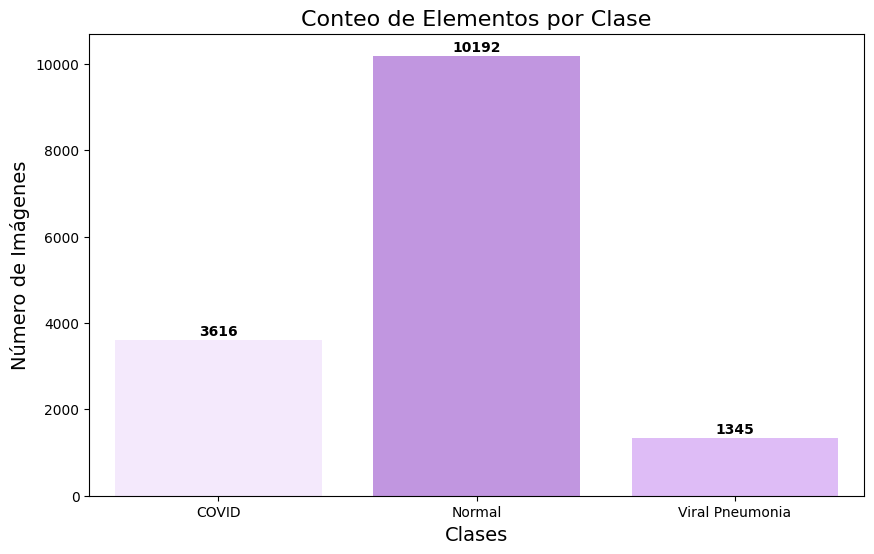

In [ ]:
# Crear un gráfico de barras usando seaborn con 'hue' especificado
plt.figure(figsize=(10, 6))
sns.barplot(x=Classes[0:3], y=conteos[0:3], palette='viridis', hue=Classes[0:3])

# Etiquetas y título
plt.xlabel('Clases', fontsize=14)
plt.ylabel('Número de Imágenes', fontsize=14)
plt.title('Conteo de Elementos por Clase', fontsize=16)

# Definir colores personalizados para las barras
colors = ['#f5e6ff', '#c38aec', '#e0b3ff']  # Los colores para COVID, Normal, Viral Pneumonia respectivamente

# Usar los colores personalizados en el gráfico
sns.barplot(x=Classes[0:3], y=conteos[0:3], palette=colors)

# Añadir valores en la parte superior de cada barra
for i, v in enumerate(conteos[0:3]):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.show()

In [29]:
print(conteos[0:3])
print(Classes[0:3])

[3616, 10192, 1345]
['COVID', 'Normal', 'Viral Pneumonia']


# Preparando Conjuntos de Entrenamiento y Prueba

In [ ]:
class_names = ['Normal', 'Viral Pneumonia', 'Covid 19']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        
        if len(images) >= 40:
            selected_images = random.sample(images, 40)
        else:
            selected_images = images  # Use all available images if less than 60
        
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)


# Creando Dataset Personalizado

In [ ]:
#Balanced Sampling
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Normal', 'Viral Pneumonia', 'Covid 19']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Transformaciones de Imágenes

In [34]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Preparar DataLoader

In [35]:
train_dirs = {
    'Normal': 'COVID-19 Radiography Database/Normal',
    'Viral Pneumonia': 'COVID-19 Radiography Database/Viral Pneumonia',
    'Covid 19': 'COVID-19 Radiography Database/Covid 19'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10152 Normal examples
Found 1305 Viral Pneumonia examples
Found 3576 Covid 19 examples


In [36]:
test_dirs = {
    'Normal': 'COVID-19 Radiography Database/test/Normal',
    'Viral Pneumonia': 'COVID-19 Radiography Database/test/Viral Pneumonia',
    'Covid 19': 'COVID-19 Radiography Database/test/Covid 19'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 40 Normal examples
Found 40 Viral Pneumonia examples
Found 40 Covid 19 examples


In [37]:
#Visualizar que las clases se balancearon
from torch.utils.data import WeightedRandomSampler

class_counts = {
    'Normal': len(train_dataset.images['Normal']),
    'Viral Pneumonia': len(train_dataset.images['Viral Pneumonia']),
    'Covid 19': len(train_dataset.images['Covid 19']),
}

total_samples = sum(class_counts.values())
weights = {class_name: total_samples / count for class_name, count in class_counts.items()}
print("Class weights:", weights)

# Assign a weight to each image based on its class
sample_weights = []
for class_name in ['Normal', 'Viral Pneumonia', 'Covid 19']:
    class_weight = weights[class_name]
    sample_weights.extend([class_weight] * len(train_dataset.images[class_name]))  # Add the weight for each image

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

Class weights: {'Normal': 1.4807919621749408, 'Viral Pneumonia': 11.519540229885058, 'Covid 19': 4.203859060402684}


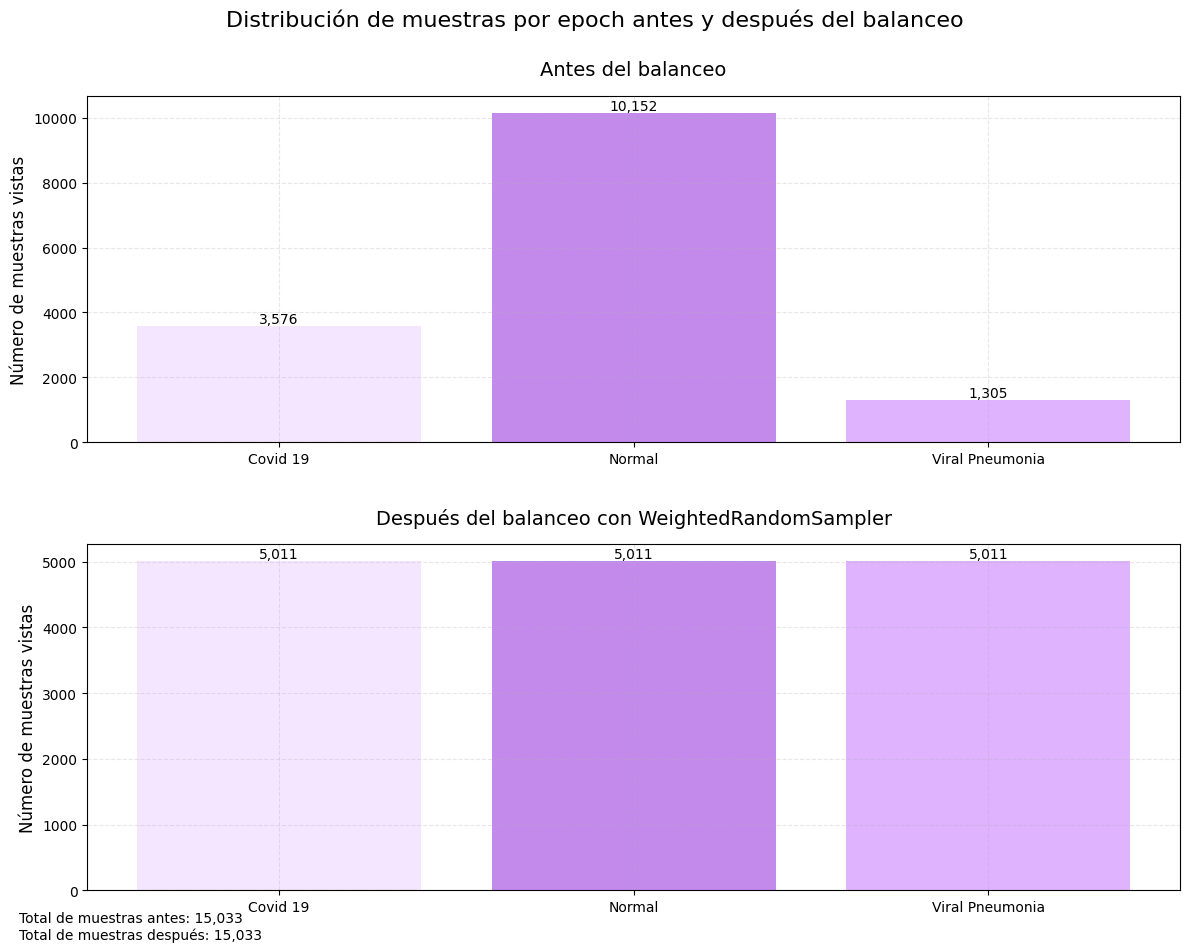

In [40]:
#Ver clases balanceadas
# Calculamos el número total de muestras por epoch
samples_per_epoch = len(train_dataset)  # Este es el número total de muestras que verá por epoch

# Calculamos cuántas veces se ve cada clase antes del balanceo
# La probabilidad de selección será proporcional a la frecuencia de la clase
class_counts_before = {
    'Covid 19': len(train_dataset.images['Covid 19']),
    'Normal': len(train_dataset.images['Normal']),
    'Viral Pneumonia': len(train_dataset.images['Viral Pneumonia']),
    
}

total_samples = sum(class_counts_before.values())
samples_seen_before = {
    class_name: int((count / total_samples) * samples_per_epoch)
    for class_name, count in class_counts_before.items()
}

# Para el segundo gráfico (después del balanceo)
# Con WeightedRandomSampler, cada clase se verá aproximadamente el mismo número de veces
balanced_samples = samples_per_epoch // len(class_counts_before)
samples_seen_after = {
    class_name: balanced_samples
    for class_name in class_counts_before.keys()
}

# Definir una paleta de colores pastel
colors = ['#f5e6ff', '#c38aec', '#e0b3ff']  # Rosa pastel, verde pastel, azul pastel

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Distribución de muestras por epoch antes y después del balanceo', 
             fontsize=16, y=0.95)

# Primer subplot (antes del balanceo)
bars1 = ax1.bar(samples_seen_before.keys(), 
                samples_seen_before.values(),
                color=colors)
ax1.set_title('Antes del balanceo', pad=15, fontsize=14)
ax1.set_ylabel('Número de muestras vistas', fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')

# Añadir valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Segundo subplot (después del balanceo)
bars2 = ax2.bar(samples_seen_after.keys(), 
                samples_seen_after.values(),
                color=colors)
ax2.set_title('Después del balanceo con WeightedRandomSampler', pad=15, fontsize=14)
ax2.set_ylabel('Número de muestras vistas', fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--')

# Añadir valores sobre las barras
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=3)

# Añadir información adicional
total_before = sum(samples_seen_before.values())
total_after = sum(samples_seen_after.values())
fig.text(0.02, 0.02, f'Total de muestras antes: {total_before:,}\nTotal de muestras después: {total_after:,}', 
         fontsize=10, ha='left')

# Mostrar el gráfico
plt.show()

In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of balanced training batches:', len(dl_train))
print('Number of test batches:', len(dl_test))

Number of balanced training batches: 2506
Number of test batches: 20


# Visualización de Datos

In [84]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

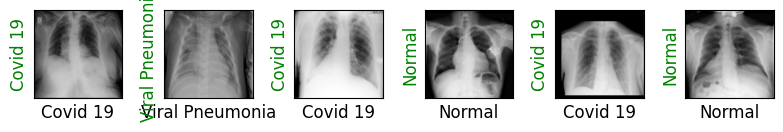

In [85]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

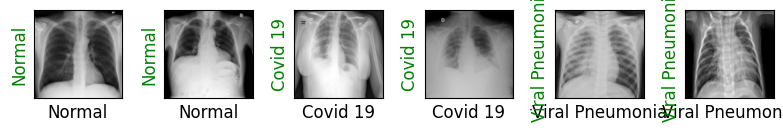

In [86]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creando el Modelo

In [87]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [89]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

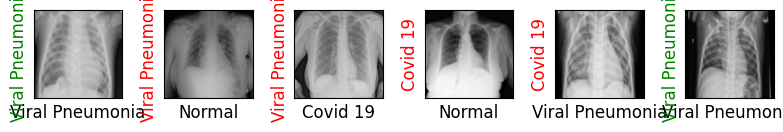

In [90]:
show_preds()

# Entrenando el Modelo

In [93]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.94:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.2136, Accuracy: 0.9333


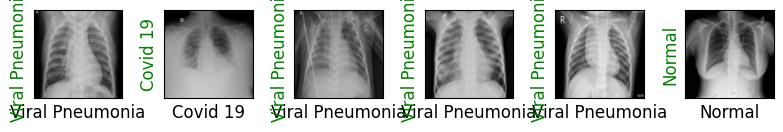

Evaluating at step 20
Validation Loss: 0.1833, Accuracy: 0.9583


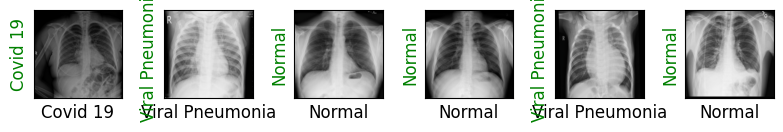

Performance condition satisfied, stopping..
CPU times: total: 3min 14s
Wall time: 54.4 s


In [94]:
%%time

train(epochs=1)

# Resultados Finales

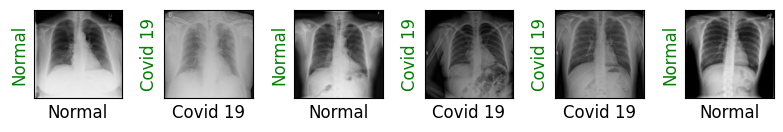

In [95]:
show_preds()

In [96]:
import pandas as pd
from sklearn.metrics import precision_score, f1_score, accuracy_score

def evaluate_model():
    # Evaluar después del entrenamiento
    print('Evaluating model after training...')
    
    # Configura el modelo en modo evaluación
    resnet18.eval()

    # Variables para almacenar las predicciones y las etiquetas reales
    all_preds = []
    all_labels = []

    # Realizar las predicciones en el conjunto de test
    with torch.no_grad():  # No necesitamos gradientes para la evaluación
        for images, labels in dl_test:
            outputs = resnet18(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular las métricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision_micro = precision_score(all_labels, all_preds, average='micro')
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    precision_weighted = precision_score(all_labels, all_preds, average='weighted')
    precision_per_class = precision_score(all_labels, all_preds, average=None)

    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    # Crear un DataFrame para mostrar las métricas por clase
    metrics_dict = {
        'Metric': ['Precision', 'F1 Score', 'Accuracy'],
        'Normal': [precision_per_class[0], f1_per_class[0], accuracy],
        'Viral Pneumonia': [precision_per_class[1], f1_per_class[1], accuracy],
        'Covid 19': [precision_per_class[2], f1_per_class[2], accuracy],
    }

    # Crear el DataFrame de métricas por clase
    metrics_df = pd.DataFrame(metrics_dict)
    
    # Crear las métricas de promedios
    metrics_avg_dict = {
        'Metric': ['Micro Average', 'Macro Average', 'Weighted Average'],
        'Normal': [precision_micro, precision_macro, precision_weighted],
        'Viral Pneumonia': [f1_micro, f1_macro, f1_weighted],
        'Covid 19': [accuracy, accuracy, accuracy],  # Usamos accuracy para los promedios
    }

    # Crear el DataFrame de métricas promedio
    metrics_avg_df = pd.DataFrame(metrics_avg_dict)

    # Concatenar ambos DataFrames
    final_df = pd.concat([metrics_df, metrics_avg_df], ignore_index=True)

    # Mostrar el DataFrame final
    return final_df

# Llamar a la función de evaluación después del entrenamiento
final_df = evaluate_model()
final_df.head(100)


Evaluating model after training...


,Metric,Normal,Viral Pneumonia,Covid 19
0,Precision,0.794872,1.000000,1.000000
1,F1 Score,0.885714,0.955224,0.951456
2,Accuracy,0.933333,0.933333,0.933333
3,Micro Average,0.933333,0.933333,0.933333
4,Macro Average,0.931624,0.930798,0.933333
5,Weighted Average,0.947009,0.935572,0.933333


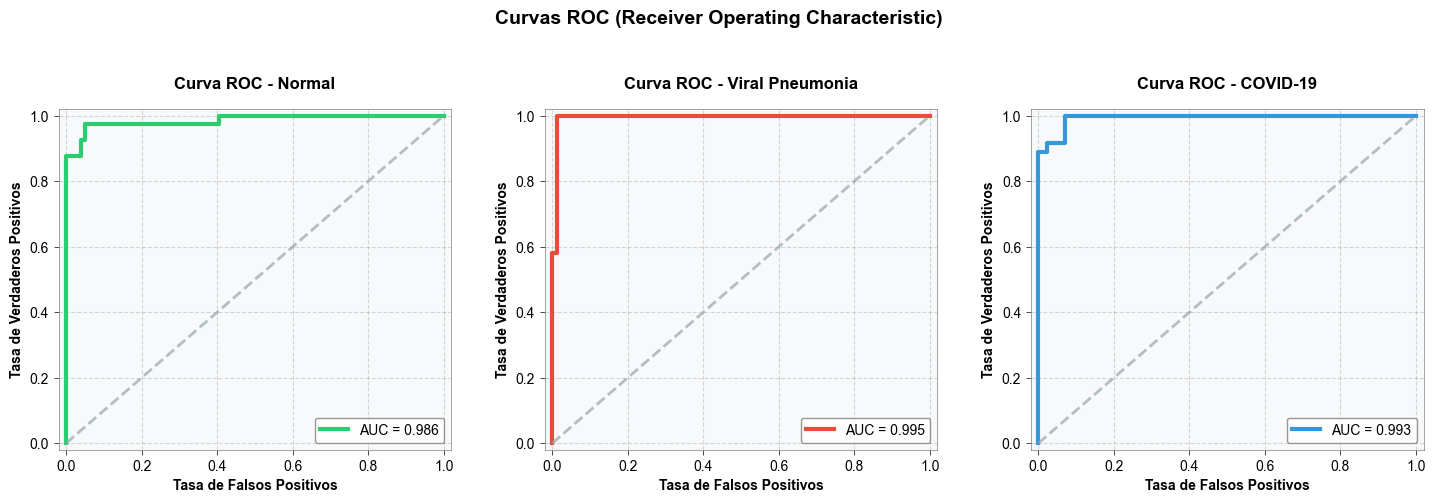

In [110]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Configurar el estilo general de matplotlib
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (15, 5)

# Asegurarse de que el modelo está en modo evaluación
resnet18.eval()

# Inicializar el label_binarizer
label_binarizer = LabelBinarizer().fit([0, 1, 2])

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in dl_test:
        outputs = resnet18(images)
        probas = torch.softmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(probas.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true_bin = label_binarizer.transform(y_true)

# Configuración de nombres de clases y colores
target_names = ['Normal', 'Viral Pneumonia', 'COVID-19']
colors = ['#2ecc71', '#e74c3c', '#3498db']  # Verde, Rojo, Azul

# Crear la figura
fig = plt.figure(facecolor='white')

# Crear los subplots
for i, (name, color) in enumerate(zip(target_names, colors), 1):
    ax = plt.subplot(1, 3, i)
    ax.set_facecolor('#f8f9fa')
    
    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_true_bin[:, i-1], y_pred[:, i-1])
    roc_auc = auc(fpr, tpr)
    
    # Dibujar la curva ROC
    ax.plot(fpr, tpr, color=color, lw=3, 
            label=f'AUC = {roc_auc:.3f}')
    
    # Añadir la línea diagonal
    ax.plot([0, 1], [0, 1], '--', color='#95a5a6', lw=2, alpha=0.7)
    
    # Personalizar los ejes
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    
    # Añadir cuadrícula
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Mejorar las etiquetas y títulos
    ax.set_xlabel('Tasa de Falsos Positivos', fontsize=10, fontweight='bold')
    ax.set_ylabel('Tasa de Verdaderos Positivos', fontsize=10, fontweight='bold')
    ax.set_title(f'Curva ROC - {name}', fontsize=12, fontweight='bold', pad=15)
    
    # Personalizar la leyenda
    ax.legend(loc='lower right', frameon=True, 
             facecolor='white', edgecolor='gray', 
             fontsize=10)
    
    # Añadir ticks más finos
    ax.tick_params(width=0.5)
    
    # Añadir un borde al subplot
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.5)

# Ajustar el espaciado entre subplots
plt.tight_layout(pad=3.0)

# Añadir un título general
fig.suptitle('Curvas ROC (Receiver Operating Characteristic)', 
            fontsize=14, fontweight='bold', y=1.05)

plt.show()

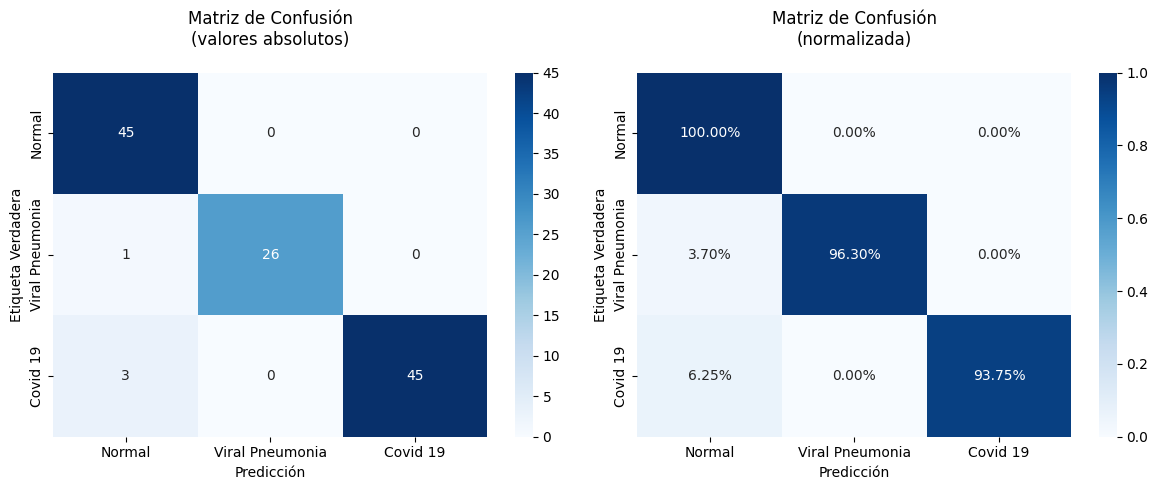

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_predictions(model, dataloader):
    """Obtiene predicciones y etiquetas verdaderas del modelo."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Obtener predicciones
y_pred, y_true = get_predictions(resnet18, dl_test)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Normalizar la matriz de confusión
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Configurar el estilo
plt.style.use('default')
plt.figure(figsize=(12, 5))

# Plot 1: Matriz de confusión con números absolutos
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión\n(valores absolutos)', pad=20)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Predicción')

# Plot 2: Matriz de confusión normalizada
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión\n(normalizada)', pad=20)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Predicción')

plt.tight_layout()
plt.show()